###  Linking Individual Differences in Ego-Network Density to  Connectivity 

This notebook reproduces the analysis from the second part of the results section, which deal with the relationship between density of the social network and functional connectivity.

#### Import required modules

In [1]:
from __future__ import print_function 
import warnings
warnings.filterwarnings('ignore')

import os, sys, pickle, nilearn

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from nilearn import plotting
import pandas as pd
from mne.stats import fdr_correction
from scipy import stats
from scipy.stats import linregress

import seaborn as sns
sns.set_style('ticks')

import matplotlib.pyplot as plt
%matplotlib inline

####  Setting up variables, files, folders

In [2]:
home_path               = '../..'

data_dir                =  os.path.join(home_path, 'data', 'connectivity_matrices') # folder containing the connectivity data for a prior network analysis
id_density_sheet        =  os.path.join(home_path, 'data', 'datasheets', 'pID_social_networks.csv') # sheet containing pID and density 
networks_result_path    =  os.path.join(home_path, 'data', 'datasheets', 'delta_connectivity_networks.csv') # path for network-strength results - extracted in previous notebook and saved for clarity 
connectivity_data_file  =  os.path.join(home_path, 'data', 'datasheets', 'connectivity_data_array.pckl') #  path for stacked connectivity matrices - extracted in previous notebook and saved for clarity

#### Read in the datasheet containing pIDs and Density variable

In [3]:
df_social = pd.read_csv(id_density_sheet)

#### Analysis at the egde level

In [4]:
with open(connectivity_data_file) as f:         #load individual edge-data (extracted and saved in previous notebook)
    res_array, subjects = pickle.load(f)
subjects_list = [s.replace('_Fair_Unfair_CorrelationMat.npz','')  for s in subjects]

n_subjs = res_array.shape[3]
n_nodes = res_array.shape[1]

fair_corrs = res_array[0,:,:,:]
unfair_corrs = res_array[1,:,:,:]
 
corr_r_results = np.zeros((n_nodes, n_nodes))  #holding results for correlations
corr_p_results = np.zeros((n_nodes, n_nodes))

corr_p_results_uf =  np.zeros((n_nodes, n_nodes)) #holding results for regression
corr_p_results_f =  np.zeros((n_nodes, n_nodes))

df_edge = pd.DataFrame(index= range(n_subjs), columns= ['subjs','edge_unfair_clean','edge_fair_clean','edge_delta_clean'])
        

for x in range(n_nodes):
    for y in range(n_nodes):

        df_edge['subjs'] = subjects_list
        df_edge['edge_unfair_clean']=unfair_corrs[x, y, :]
        df_edge['edge_fair_clean']=fair_corrs[x, y, :]
        df_edge['edge_delta_clean']=  unfair_corrs[x, y, :] - fair_corrs[x, y, :]
            
        df_combined = df_edge.merge(df_social, left_on=('subjs'), right_on=('pID'))

        #correlation
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_combined.edge_delta_clean , df_combined.density)
        corr_r_results[x,y] = round(r_value,2)
        corr_p_results[x,y] = p_value #round(p_value,2)
       
        #regression
        mod = smf.ols(formula = 'density ~ edge_unfair_clean + edge_fair_clean', data = df_combined)
        res = mod.fit()
        corr_p_results_uf[x,y] = res.pvalues['edge_unfair_clean']
        corr_p_results_f[x,y] = res.pvalues['edge_fair_clean']

#### FDR correction

In [5]:
indix = np.tril_indices_from(corr_p_results_uf, k =-1)
pvals = corr_p_results[indix]

reject_fdr, pval_fdr = fdr_correction(pvals, alpha=0.05)
print(reject_fdr.tolist())



###IMPROVE THIS!!!
print(reject_fdr.tolist()[27])  #this edge is significant, it corresponds to l-r TPJ
print(pvals.tolist()[27])

tri = np.ones((n_nodes, n_nodes))
tri[indix] = pval_fdr
covarying_edges = np.where(tri<0.05,1,0)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
True
0.000660303985323


#### Plotting edge-wise results onto brain 

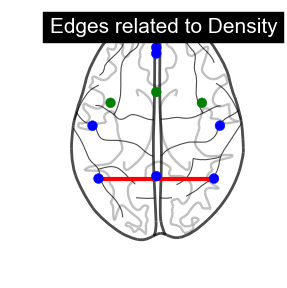

In [6]:
#see other notebook for images of brain networks/meta-analysis
networks_coords = [(0,16,32),(38,7,-4),(-38,7,-4),(0,53,30),(0,48,-18),
                   (0,-54,44),(48,-56,23),(-48,-56,23),(53,-12,-16),(-53,-12,-16)]

networks_cols = ['green','green','green','blue','blue',
                 'blue','blue','blue','blue', 'blue']

covarying_edges[np.triu_indices_from(covarying_edges, 1)] = covarying_edges.T[np.triu_indices_from(covarying_edges, 1)]
plotting.plot_connectome(covarying_edges, networks_coords, 
                         display_mode = 'z', 
                         annotate = False,
                         node_color= networks_cols,
                         title = 'Edges related to Density');

#### Scatterplot: Density vs. TPJ-connectivity

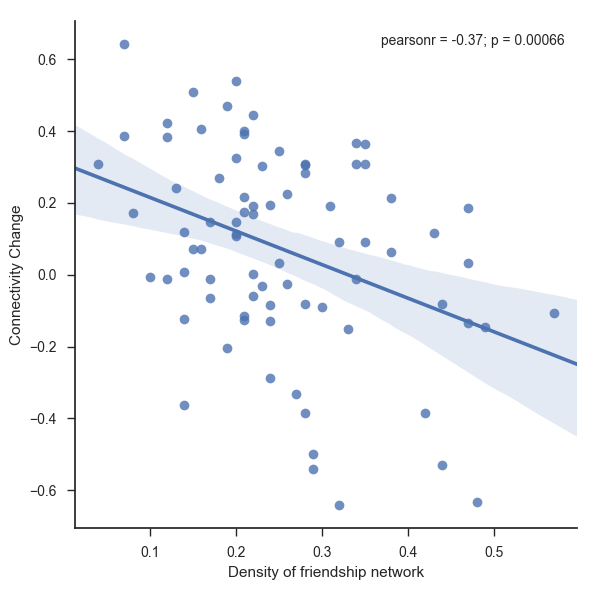

In [7]:
###IMPROVE THIS

#corresponds to the left/right TPJ
x = 6 #print(networks_labels[x]) note: 6 = XXX
y = 7 #print(networks_labels[y]) note: 7 = XXX

df_edge = pd.DataFrame(index = range(n_subjs), columns = ['pID','edge_delta_clean'])  
df_edge['pID'] = subjects_list
df_edge['edge_delta_clean'] = unfair_corrs[x, y, :] - fair_corrs[x, y, :]

combined_df = df_edge.merge(df_social, left_on = ('pID'), right_on = ('pID'))
combined_df = combined_df.rename(columns = {'edge_delta_clean': 'Connectivity Change', 'density': 'Density of friendship network'})

g = sns.JointGrid(y="Connectivity Change", x="Density of friendship network", data=combined_df, ratio=100);
g.plot_joint(sns.regplot);
g.annotate(stats.pearsonr);
g.ax_marg_x.set_axis_off();
g.ax_marg_y.set_axis_off();
plt.show()

#### Analysis at the network level

In [8]:
#load the networth-strength results (computed in previous notebook)
df_conn = pd.read_csv(networks_result_path, )#
df_conn = df_conn.rename(columns={'Unnamed: 0': 'pID'})

df_combined_nets = df_conn.merge(df_social, left_on = 'pID',  right_on=('pID')) 

# assess whether density relates to network-strength measures during exclusion, contrl for inclusion
mod = smf.ols(formula = 'density ~ Ment_E + Ment_I', data = df_combined_nets)
res = mod.fit()
print("Mentalizing_Exclusion: p={}".format(round(res.pvalues['Ment_E'],5)))  

mod = smf.ols(formula = 'density ~ SP_E + SP_I', data = df_combined_nets)
res = mod.fit()
print("Social Pain_Exclusion: p={}".format(round(res.pvalues['SP_E'],5)))  

mod = smf.ols(formula = 'density ~ Across_E + Across_I', data = df_combined_nets)
res = mod.fit()
print("Across_Exclusion: p={}".format(round(res.pvalues['Across_E'],5)))  

#There are no effects between density and exclusion assessed via average within-network strength:

Mentalizing_Exclusion: p=0.13235
Social Pain_Exclusion: p=0.8078
Across_Exclusion: p=0.3785


* 2017 | Ralf Schmaelzle | Matthew Brook O'Donnell